# Deep Learning Summarizer

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset
import opendatasets as od
from attention import AttentionLayer
import re
import contractions
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow.keras.backend as K
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
od.download('https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail', data_dir='./data/')

Skipping, found downloaded files in "./data/newspaper-text-summarization-cnn-dailymail" (use force=True to force download)


In [30]:
np.random.seed(128)
total_rows = 287113
skip_size = int(total_rows * 0.8)
skip_sample = np.random.choice(range(1, total_rows+1), size=skip_size, replace=False).tolist()

In [31]:
train_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv', skiprows=skip_sample)
validation_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_df = pd.read_csv('./data/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(57423, 3)
(13368, 3)
(11490, 3)


In [32]:
df = pd.concat([train_df, validation_df, test_df], keys=['train', 'validation', 'test'], ignore_index=False)

In [33]:
df['article'].head(10)

train  0    By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr...
       1    By . Margot Peppers . Nigerian and Cameroonian pop star Dencia has hit out at Lupita Nyong'o for her new contract with Lancome, accusing her of bowing to 'white people companies'. In an angry twee...
       2    By . Daily Mail Reporter . PUBLISHED: . 19:44 EST, 10 October 2012 . | . UPDATED: . 05:29 EST, 11 October 2012 . A Florida woman said she was humiliated by local police as she accused them of hogt...
       3    Kabul, Afghanistan (CNN) -- China's top security official paid a surprise visit to Afghanistan, where he met with President Hamid Karzai on issues ranging from investment and bilateral trade to to...
       4    (CNN) -- A University of Wisconsin senior official resigned after making unwanted sexual advances to a male student employee of the school's

In [34]:
df['highlights'].head(10)

train  0    Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown...
       1                         Dencia's comment is hypocritical considering she recently courted controversy for marketing 'dark spot remover' Whitenicious, which is frequently used as a skin-whitening cream .
       2                                                Ashleigh Davis, 32, arrested last year after a fight with another woman .\nShe claims she was hogtied and paraded topless by officers as she was arrested .
       3    China's top security official visited Afghanistan on Saturday and met with President Hamid Karzai .\nVisit was first by a top Chinese official since 1955, according to China's state-run Xinhua age...
       4    John Chadima resigned after the allegations surfaced .\nChadima was the senior associate athletic director at the University of Wisconsin .\

Things to resolve:

- Text inside parenthesis
- Text inside brackets
- Text inside curly brackets
- Words of length less than 1
- Text with symbols i.e. @, $, etc. (In general all I want is english alphabet characters and possibly numbers)
- URLs i.e. www.comsol.com
- Contractions
- Stop Words
- Lower Case
- New lines (\n) and possibly tabs (\t)


In [27]:
def clean_text(text, summary=False):
    new_text = text.lower()
    new_text = re.sub(r'\([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', new_text) # Removes text inside (), [], {}
    new_text = re.sub(r'\b(?:https?://)?(?:www\.)?\S+\.com\b', '', new_text) # Removes URLs
    new_text = re.sub(r'[\n\t]', '', new_text) # New lines and tabs
    new_text = ' '.join([contractions.fix(w) for w in new_text.split(' ')]) # Fixes contractions
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # Remove non-words
    new_text = re.sub(r'\b\w*[^\w\s]+\w*\b', '', new_text) # Remove symbols from words
    new_text = re.sub(r'[^a-zA-z]', ' ', new_text) # Keeps all English alphabet characters
    stop_words = set(stopwords.words('english'))
    if not summary:
        new_text = [w for w in new_text.split() if not w in stop_words] # Removing stop words from non abstract text
    else:
        new_text = new_text.split()
    new_text = [w for w in new_text if len(w) > 1] # Removing remaining words with only 1 character
    return (' '.join(new_text)).strip() 

In [35]:
df['cleaned_article'] = df['article'].apply(lambda x: clean_text(x))

In [36]:
df['cleaned_article'].head(10)

train  0    associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late s...
       1    margot peppers nigerian cameroonian pop star dencia hit lupita nyong new contract lancome accusing bowing white people companies angry tweet directed years slave star wrote oh lupita_nyongo cln ta...
       2    daily mail reporter published est october updated est october florida woman said humiliated local police accused hogtying parading around topless bashing teeth arrest last year ashleigh davis ocal...
       3    kabul afghanistan china top security official paid surprise visit afghanistan met president hamid karzai issues ranging investment bilateral trade terrorism drug trafficking china state run news a...
       4    university wisconsin senior official resigned making unwanted sexual advances male student employee school athletic department according rep

In [37]:
df['cleaned_highlights'] = df['highlights'].apply(lambda x: f'<SOS> {clean_text(x, summary=True)} <EOS>')

In [38]:
df['cleaned_highlights'].head(10)

train  0    <SOS> bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown co...
       1                      <SOS> dencia comment is hypocritical considering she recently courted controversy for marketing dark spot remover whitenicious which is frequently used as skin whitening cream <EOS>
       2                                                <SOS> ashleigh davis arrested last year after fight with another woman she claims she was hogtied and paraded topless by officers as she was arrested <EOS>
       3    <SOS> china top security official visited afghanistan on saturday and met with president hamid karzai visit was first by top chinese official since according to china state run xinhua agency china...
       4    <SOS> john chadima resigned after the allegations surfaced chadima was the senior associate athletic director at the university of wisconsin

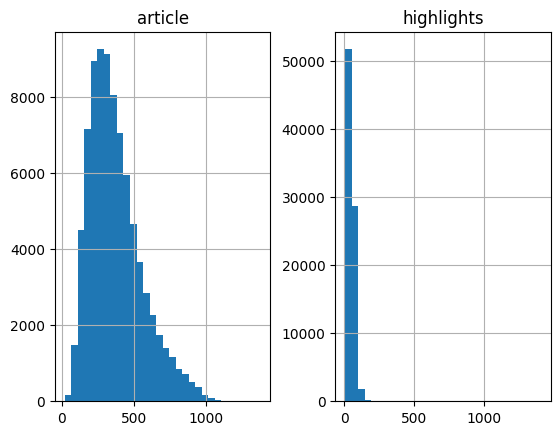

In [39]:
import matplotlib.pyplot as plt

article_word_count = []
highlights_word_count = []

for document in df['cleaned_article']:
    article_word_count.append(len(document.split(' ')))
    
for document in df['cleaned_highlights']:
    highlights_word_count.append(len(document.split(' ')))
    
count_df = pd.DataFrame({'article': article_word_count, 'highlights': highlights_word_count})
count_df.hist(bins=30)
plt.show()

In [40]:
print(f"Mean Article Word Count: {np.mean(article_word_count)}")
print(f"Median Article Word Count: {np.median(article_word_count)}")
print(f"Mean Highlights Word Count: {np.mean(highlights_word_count)}")
print(f"Median Highlights Word Count: {np.median(highlights_word_count)}")

Mean Article Word Count: 374.9631263596699
Median Article Word Count: 341.0
Mean Highlights Word Count: 49.96654148588374
Median Highlights Word Count: 47.0


In [41]:
train_df_cleaned, validation_df_cleaned, test_df_cleaned = df.xs('train'), df.xs('validation'), df.xs('test')

print(train_df_cleaned.shape[0])
print(validation_df_cleaned.shape[0])
print(test_df_cleaned.shape[0])

57423
13368
11490


In [42]:
max_article_len = 350
max_highlights_len = 48

In [43]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_article']))
X_train = X_tokenizer.texts_to_sequences(list(train_df_cleaned['cleaned_article']))
X_train = pad_sequences(X_train, maxlen=max_article_len, padding='post')

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train_df_cleaned['cleaned_highlights']))
y_train = y_tokenizer.texts_to_sequences(list(train_df_cleaned['cleaned_highlights']))
y_train = pad_sequences(y_train, maxlen=max_article_len, padding='post')

with open("../models/X_tokenizer.pickle", "wb") as handle:
    pickle.dump(X_tokenizer, handle)
    
with open("../models/y_tokenizer.pickle", "wb") as handle:
    pickle.dump(y_tokenizer, handle)

In [44]:
X_vocab = len(X_tokenizer.word_index) + 1
y_vocab = len(y_tokenizer.word_index) + 1

print(X_vocab)
print(y_vocab)

199308
72158


In [50]:
K.clear_session()

embed_dim = 90
latent_dim = 150

# Encoder
encoder_input = Input(shape=(max_article_len, ))
encoder_embed = Embedding(X_vocab, embed_dim, trainable=True)(encoder_input)
encoder_bidirectional = Bidirectional(LSTM(75, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_output_bi, forward_h, backward_h, forward_c, backward_c = encoder_bidirectional(encoder_embed)
state_h = Concatenate(axis=-1)([forward_h, backward_h])
state_c = Concatenate(axis=-1)([forward_c, backward_c])
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_output_bi, initial_state=[state_h, state_c])
# encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# Decoder
decoder_input = Input(shape=(None, ))
decoder_embed = Embedding(y_vocab, embed_dim, trainable=True)(decoder_input)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_output, _, _ = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

# Attention
attention = AttentionLayer()
attention_output, _ = attention([encoder_output3, decoder_output])

# Concatenate Attention with LSTM Output
concatenate = Concatenate(axis=-1)([decoder_output, attention_output])
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_output = decoder_dense(concatenate)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 350, 90)   │ 17,937,720 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 350,      │     99,600 │ embedding[0][0]   │
│ (Bidirectional)     │ 150), (None, 75), │            │                   │
│                     │ (None, 75),       │            │                   │
│                     │ (None, 75),       │            │                   │
│                     │ (None, 75)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 150)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 350,      │    180,600 │ bidirectional[0]… │
│                     │ 150), (None,      │            │ concatenate[0][0… │
│                     │ 150), (None,      │            │ concatenate_1[0]… │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 350,      │    180,600 │ lstm_1[0][0]      │
│                     │ 150), (None,      │            │                   │
│                     │ 150), (None,      │            │                   │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 90)  │  6,494,220 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 350,      │    180,600 │ lstm_2[0][0]      │
│                     │ 150), (None,      │            │                   │
│                     │ 150), (None,      │            │                   │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    144,600 │ embedding_1[0][0… │
│                     │ 150), (None,      │            │ lstm_3[0][1],     │
│                     │ 150), (None,      │            │ lstm_3[0][2]      │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │     45,150 │ lstm_3[0][0],     │
│ (AttentionLayer)    │ 150), (None,      │            │ lstm_4[0][0]      │
│                     │ None, 350)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 300) │          0 │ lstm_4[0][0],   

 Total params: 46,982,648 (179.22 MB)

 Trainable params: 46,982,648 (179.22 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [52]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [53]:
X_val = X_tokenizer.texts_to_sequences(list(validation_df_cleaned['cleaned_article']))
X_val = pad_sequences(X_val, maxlen=max_article_len, padding='post')
y_val = y_tokenizer.texts_to_sequences(list(validation_df_cleaned['cleaned_highlights']))
y_val = pad_sequences(y_val, maxlen=max_highlights_len, padding='post')

In [54]:
X_train_m = [X_train, y_train[:, :-1]]
y_train_m = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:]

X_val_m = [X_val, y_val[:, :-1]]
y_val_m = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]

In [55]:
history = model.fit(X_train_m, y_train_m, batch_size=32, epochs=20, validation_data=(X_val_m, y_val_m), callbacks=[early_stop], verbose=1)

Epoch 1/20
